In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Read in our data, this is the ohlc data for the stock 7238 on the Tokyo Stock Exchange from 2014-2018

In [13]:
df = pd.read_csv('data/7238.csv')
df.head()

,日付,始値,高値,安値,終値,出来高,終値調整値
0,2014-01-06,469,474,461,463,501000,463
1,2014-01-07,464,468,455,457,558000,457
2,2014-01-08,463,465,457,464,305600,464
3,2014-01-09,465,465,451,456,547400,456
4,2014-01-10,456,459,452,456,476100,456


In [14]:
ohlc = df[['日付', '始値', '高値', '安値', '終値']]
ohlc.columns = ['date', 'open', 'high', 'low', 'close']
ohlc.head()

,date,open,high,low,close
0,2014-01-06,469,474,461,463
1,2014-01-07,464,468,455,457
2,2014-01-08,463,465,457,464
3,2014-01-09,465,465,451,456
4,2014-01-10,456,459,452,456


Add a 20 day simple moving average and exponential moving average.

In [15]:
ohlc['sma'] = ohlc.close.rolling(window=20).mean().round()
ohlc['ema'] = ohlc.close.ewm(span=20, adjust=False).mean().round()
ohlc.tail()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,date,open,high,low,close,sma,ema
1217,2018-12-21,188,191,180,181,212.0,207.0
1218,2018-12-25,171,172,165,166,210.0,203.0
1219,2018-12-26,167,175,167,173,208.0,200.0
1220,2018-12-27,183,184,175,182,206.0,199.0
1221,2018-12-28,180,187,179,183,205.0,197.0


Add the true range, calculated as the greastest of 
- Current high - the current low
- Current high - the previous close (abs)
- Current low - the previous close (abs)

In [26]:
def true_range(row, prev_row=None):
    ch_cl = row.high - row.low
    
    if prev_row is not None:
        ch_pc = abs(row.high - prev_row.close)
        cl_pc = abs(row.low - prev_row.close)
        
        return max(ch_cl, ch_pc, cl_pc)
    else:
        return ch_cl
    
ohlc['tr'] = ohlc.index.map(lambda i: true_range(ohlc.iloc[i], ohlc.iloc[i - 1] if i > 0 else None))
ohlc.head()

,date,open,high,low,close,sma,ema,tr,atr
0,2014-01-06,469,474,461,463,NaN,463.0,13,NaN
1,2014-01-07,464,468,455,457,NaN,462.0,13,NaN
2,2014-01-08,463,465,457,464,NaN,463.0,8,NaN
3,2014-01-09,465,465,451,456,NaN,462.0,14,NaN
4,2014-01-10,456,459,452,456,NaN,461.0,7,NaN


Next calculate the averate true range.
We will use a 14 day period and will smooth by including the previous days ATR.

`ATR = ((prev ATR x 13) + current TR) / 14`

In [36]:
def average_true_range(index, data):
    row = data.iloc[index]
    prev_row = data.iloc[index - 1]
    
    return ((prev_row.atr * 13) + row.tr) / 14

# Set the first ATR, an average of the past 14 trs.
ohlc['atr'] = np.NaN
ohlc.ix[13, 'atr'] = ohlc[:14].tr.mean()

# Calculate the ATR with smoothing based on previous ATR - TODO: try to pandaise
for i in range(14, ohlc.shape[0]):
    ohlc.ix[i, 'atr'] =  average_true_range(i, ohlc)
    
ohlc.head(21)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


,date,open,high,low,close,sma,ema,tr,atr
0,2014-01-06,469,474,461,463,NaN,463.0,13,NaN
1,2014-01-07,464,468,455,457,NaN,462.0,13,NaN
2,2014-01-08,463,465,457,464,NaN,463.0,8,NaN
3,2014-01-09,465,465,451,456,NaN,462.0,14,NaN
4,2014-01-10,456,459,452,456,NaN,461.0,7,NaN
5,2014-01-14,449,455,443,448,NaN,460.0,13,NaN
6,2014-01-15,456,459,453,459,NaN,460.0,11,NaN
7,2014-01-16,461,466,457,459,NaN,460.0,9,NaN
8,2014-01-17,455,462,454,460,NaN,460.0,8,NaN
9,2014-01-20,462,468,461,468,NaN,461.0,8,NaN


Cut off the first 19 rows that don't have valid emas

In [138]:
ohlc = ohlc[19:]
ohlc.reset_index(inplace=True, drop=True)
ohlc.head()

,date,open,high,low,close,sma,ema,tr,atr
0,2014-02-03,485,485,468,468,466.0,468.0,17,17.0
1,2014-02-04,452,454,444,444,465.0,466.0,24,23.0
2,2014-02-05,443,448,420,435,464.0,463.0,28,27.0
3,2014-02-06,441,448,435,440,462.0,461.0,13,13.0
4,2014-02-07,452,455,449,454,462.0,460.0,15,15.0


Add keltner bands and the position of price in them as a portion of the distance from the ema to the outer band.

In [139]:
factor = 2.25
ohlc['ku'] = ohlc.ema + ohlc.atr * factor
ohlc['kl'] = ohlc.ema - ohlc.atr * factor
ohlc['kp'] = (ohlc.close - ohlc.ema) / (ohlc.atr * factor)
ohlc['kps'] = ohlc.kp.ewm(span=14, adjust=False).mean().round()

ohlc.tail()

,date,open,high,low,close,sma,ema,tr,atr,ku,kl,kp,kps
1198,2018-12-21,188,191,180,181,212.0,207.0,11,11.0,231.75,182.25,-1.050505,-1.0
1199,2018-12-25,171,172,165,166,210.0,203.0,16,16.0,239.00,167.00,-1.027778,-1.0
1200,2018-12-26,167,175,167,173,208.0,200.0,9,9.0,220.25,179.75,-1.333333,-1.0
1201,2018-12-27,183,184,175,182,206.0,199.0,11,11.0,223.75,174.25,-0.686869,-1.0
1202,2018-12-28,180,187,179,183,205.0,197.0,8,8.0,215.00,179.00,-0.777778,-1.0


Lets graph some things

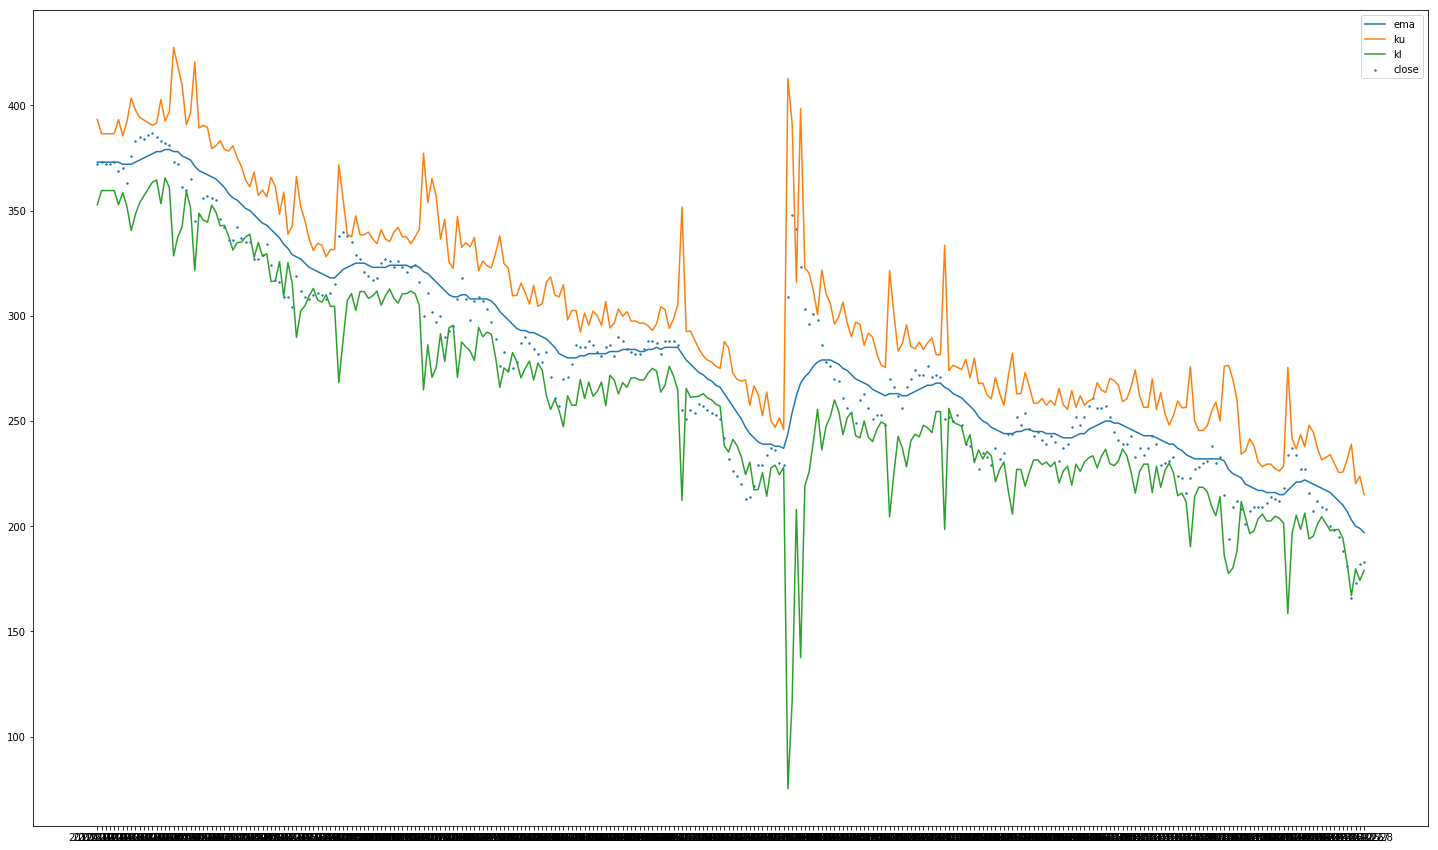

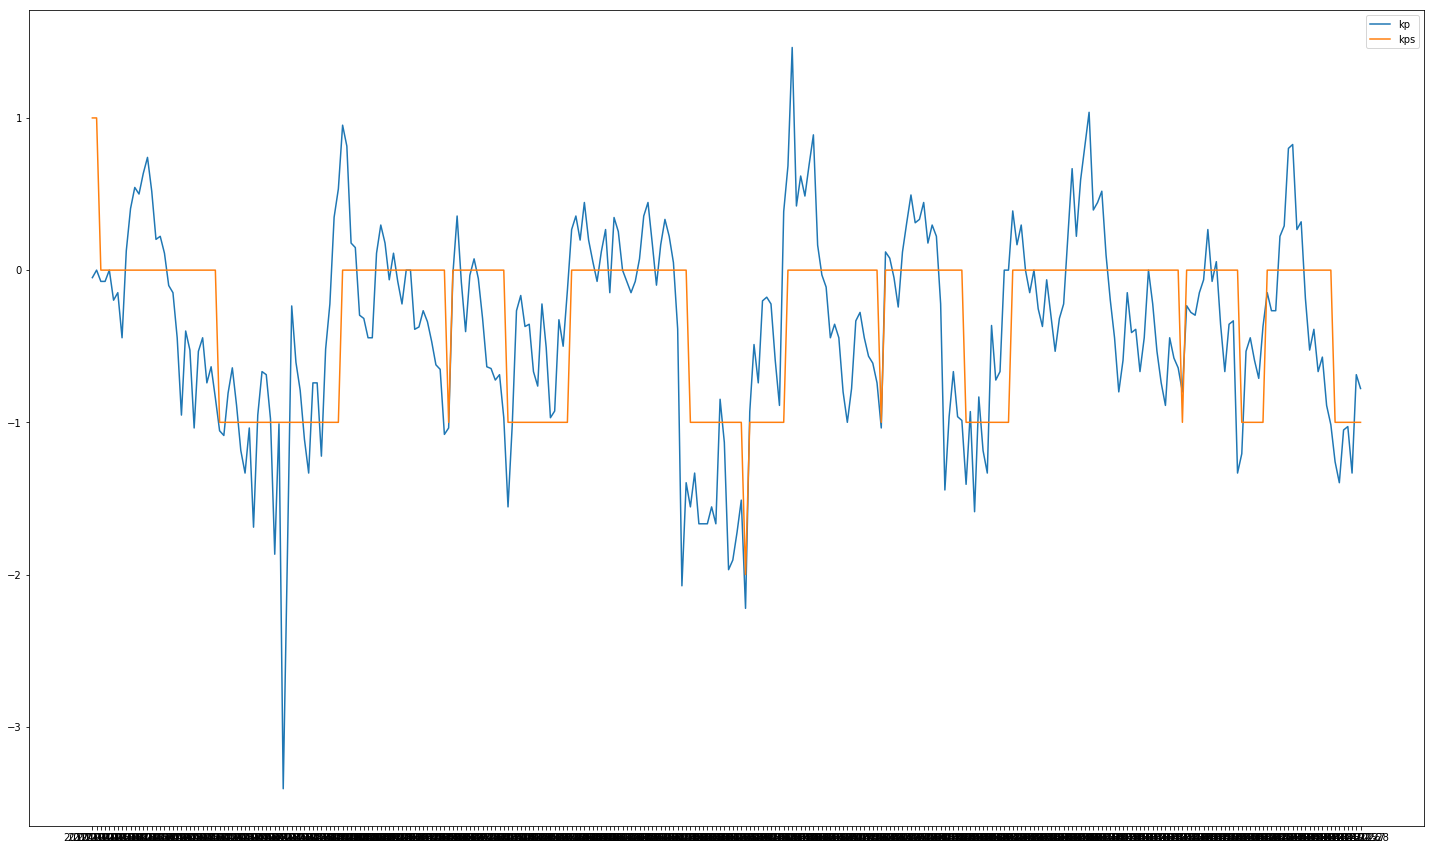

In [272]:
subset = ohlc.tail(300).reset_index(drop=True)

plt.figure(figsize=(25,15))

plt.plot(subset.date, subset.ema)
plt.plot(subset.date, subset.ku)
plt.plot(subset.date, subset.kl)
plt.scatter(subset.date, subset.close, s=2)

plt.legend()

plt.show()

plt.figure(figsize=(25,15))

plt.plot(subset.date, subset.kp)
plt.plot(subset.date, subset.kps)

plt.legend()

plt.show()